In [ ]:
!pip install mlflow

All required commands to install MLflow on EC2:

Login to AWS console.
Create IAM user with AdministratorAccess
Export the credentials in your AWS CLI by running "aws configure"
Create a s3 bucket
Create EC2 machine (Ubuntu) & add Security groups 5000 port
Run the following command on EC2 machine

sudo apt update

sudo apt install python3-pip

sudo apt install pipenv

sudo apt install virtualenv

mkdir mlflow

cd mlflow

pipenv install mlflow

pipenv install awscli

pipenv install boto3

pipenv shell


## Then set aws credentials
aws configure


#Finally 
mlflow server -h 0.0.0.0 --default-artifact-root s3://mlflow-test-23

#open Public IPv4 DNS to the port 5000


#set uri in your local terminal

In [ ]:
# Test mlflow

import mlflow

mlflow.set_tracking_uri("AWS_URI_HERE")

with mlflow.start_run():
    mlflow.log_param("param1", 15)
    mlflow.log_metric("metric1", 0.89)

In [6]:
#creating baseline model

import numpy as np
import pandas as pd

In [8]:
df = pd.read_csv('data/video_comments_Tqlw87XV4kU.csv')
df = df.drop(columns=['author','likeCount','publishedAt','commentId'])
df.rename(columns={"text": "clean_comment"})
df.rename(columns={'text': 'clean_comment'}, inplace=True)
df.head(5)

,clean_comment
0,7:21 the accent is killing me-
1,The smile Kanye has with North is beyond beaut...
2,🔫
3,Bet 😅
4,We made it❤❤🎉


In [10]:
from transformers import pipeline
import pandas as pd

# Load sentiment analysis pipeline on GPU (if available)
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device=0  # Use GPU (cuda:0); change to -1 for CPU
)

# Map labels to numeric values
def map_sentiment_label(label):
    if label == 'LABEL_2':  # Positive
        return 1
    elif label == 'LABEL_1':  # Neutral
        return 0
    elif label == 'LABEL_0':  # Negative
        return -1

# Ensure 'clean_comment' is string and truncate to 512 characters
df['clean_comment'] = df['clean_comment'].astype(str).str.slice(0, 512)

# Run pipeline in batch
results = sentiment_pipeline(df['clean_comment'].tolist(), batch_size=32)

# Map results back to the DataFrame
df['category'] = [map_sentiment_label(r['label']) for r in results]


Device set to use cuda:0


In [11]:
df.head()

,clean_comment,category
0,7:21 the accent is killing me-,-1
1,The smile Kanye has with North is beyond beaut...,1
2,🔫,0
3,Bet 😅,0
4,We made it❤❤🎉,1


In [13]:
df.shape

(19897, 2)

In [14]:
df.dropna(inplace=True)

In [15]:
df.drop_duplicates(inplace=True)

In [17]:
df = df[~(df['clean_comment'].str.strip() == '')]

In [18]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [19]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
df.shape

(17966, 2)

In [21]:
# Define the preprocessing function

def preprocess_comment(comment):
    if not isinstance(comment, str):
        return ""

    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except basic punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment


In [22]:
# Apply the preprocessing function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

In [23]:
df.head()

,clean_comment,category
0,721 accent killing,-1
1,smile kanye north beyond beautiful. love beyon...,1
2,,0
3,bet,0
4,made,1


In [24]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=10000)  # Bag of Words model with a limit of 1000 features

In [26]:
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']  # Assuming 'sentiment' is the target variable (0 or 1 for binary classification)

In [27]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(17966, 10000))

In [28]:
X.shape

(17966, 10000)

In [29]:
y

0       -1
1        1
2        0
3        0
4        1
        ..
19993    0
19995    1
19996    1
19998    0
19999   -1
Name: category, Length: 17966, dtype: int64

In [30]:
y.shape

(17966,)

# Step 2: Set up the MLflow tracking server locally
#RUN THIS COMMAND IN TERMINAL!
# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 127.0.0.1 --port 5000

In [32]:
import mlflow

# Set local MLflow tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [33]:
# Set or create an experiment
mlflow.set_experiment("RF Baseline")

<Experiment: artifact_location='/home/user/Youtube-Comments-Sentiment-Analysis/mlruns/1', creation_time=1752824706919, experiment_id='1', last_update_time=1752824706919, lifecycle_stage='active', name='RF Baseline', tags={}>

In [34]:
# Test mlflow

with mlflow.start_run():
    mlflow.log_param("param1", 12)
    mlflow.log_metric("metric1", 0.29)

🏃 View run classy-hawk-647 at: http://127.0.0.1:5000/#/experiments/1/runs/5096c7281da44f63bd49a48cfcca39b7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [ ]:
!pip install boto3

In [ ]:
!pip install awscli

2025/07/18 10:21:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Baseline_TrainTestSplit at: http://127.0.0.1:5000/#/experiments/1/runs/55cacd1cfe7f429d9f457a468f1d7f76
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
Accuracy: 0.4830272676683361


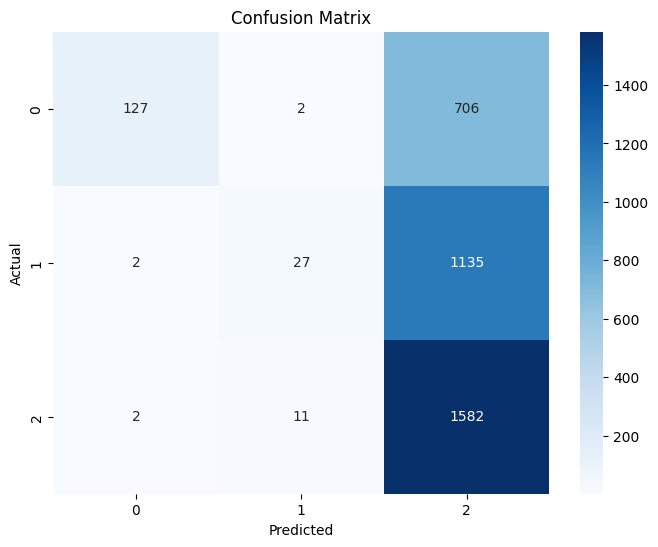

In [36]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

       # Save and log confusion matrix
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Save and log dataset
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("dataset.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.97      0.15      0.26       835
           0       0.68      0.02      0.04      1164
           1       0.46      0.99      0.63      1595

    accuracy                           0.48      3594
   macro avg       0.70      0.39      0.31      3594
weighted avg       0.65      0.48      0.36      3594



In [38]:
df.to_csv('ye_preprocessing.csv', index=False)

In [39]:
pd.read_csv('ye_preprocessing.csv').head()

,clean_comment,category
0,721 accent killing,-1
1,smile kanye north beyond beautiful. love beyon...,1
2,NaN,0
3,bet,0
4,made,1
